# Network analysis

In [1]:
import numpy as np
import pandas as pd

df_edges = pd.read_csv("../data/processed/panel/edges_no_conflicts_per_country.csv")
print("重みの統計サマリ:\n", df_edges["weight"].describe())
print("最小値:", df_edges["weight"].min(), "最大値:", df_edges["weight"].max())

重みの統計サマリ:
 count    78.000000
mean      0.076210
std       0.443191
min      -1.758008
25%      -0.000002
50%       0.000012
75%       0.006515
max       1.518449
Name: weight, dtype: float64
最小値: -1.7580083708955274 最大値: 1.5184492922856512


In [2]:
import pandas as pd
import networkx as nx

# 例：すでに作成済みの国別エッジリスト CSV を読み込む
#   columns = ["country","source","target","weight"]
df_edges = pd.read_csv("../data/processed/panel/edges_per_country.csv")

# 出力用の DataFrame リスト
degree_list = []

numeric_cols = [
    "mean_wbgt",                    # 気候層 (layer 0)

    "renewable_energy_pct",         # エネルギー層 (layer 1)
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita",

    "gdp_per_capita",               # 社会経済層 (layer 2)
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

## ネットワークの要約指標を計算する

In [19]:
# --------------------------------------------------------------------------------------
# エッジリストから国別に入次数・出次数・重み付き次数（ノードごとの “総因果強度”）を計算
# どの変数が因果的にどれだけ影響を与えている／受けているのか
# --------------------------------------------------------------------------------------
# 国ごとに処理
for country, df_ct in df_edges.groupby("country"):
    # NetworkX の DiGraph を作成
    G = nx.DiGraph()
    # ノードは numeric_cols の全ノードを必ず追加しておく
    for node in numeric_cols:
        G.add_node(node)
    # エッジを追加（重みweight付き）
    for _, row in df_ct.iterrows():
        G.add_edge(row["source"], row["target"], weight=row["weight"])

    # 各ノードごとに次数を計算
    for node in numeric_cols:
        in_deg  = G.in_degree(node)                     # エッジ数ベース（ノンウェイト）
        out_deg = G.out_degree(node)
        in_wt   = sum(d["weight"] for u, v, d in G.in_edges(node, data=True))   # 重みの合計
        out_wt  = sum(d["weight"] for u, v, d in G.out_edges(node, data=True))
        degree_list.append({
            "country": country,
            "node": node,
            "in_degree": in_deg,
            "out_degree": out_deg,
            "in_strength": in_wt,
            "out_strength": out_wt
        })

# まとめて DataFrame に
df_degrees = pd.DataFrame(degree_list)
df_degrees.to_csv("../data/processed/panel/node_strengths_per_country.csv", index=False)
print(df_degrees.head())

      country                    node  in_degree  out_degree  in_strength  \
0  Bangladesh               mean_wbgt          0           3     0.000000   
1  Bangladesh    renewable_energy_pct          4           3    -0.286006   
2  Bangladesh         fossil_fuel_pct          1           8    -1.679070   
3  Bangladesh  electricity_per_capita          2           5     0.000102   
4  Bangladesh          co2_per_capita          2           4     0.885188   

   out_strength  
0     -0.076134  
1     -1.723612  
2      1.473762  
3      0.508190  
4     -0.281334  


- out_strength（各ノードから外向きに “どれだけ強く” つながっているか＝因果 “発信力”）
- in_strength （各ノードに向かって入ってくる重みの合計＝因果 “受容力”）
などを国別に出力しておくと、たとえば「どの国で WBGT→エネルギー層の経路が特に強いのか」「エネルギー層のどの変数が社会経済層にもっとも影響を与えているのか」などが俯瞰しやすくなります。

## 層ごとの経路強度を集計する
1. Climate→Energy の総強度
- 変数ペア (mean_wbgt → any energy‐layer variable) の重みを合計

2. Energy→Socio‐Econ の総強度
- 変数ペア (any energy‐layer variable → any socio‐econ variable) の重みを合計

3. Climate→Socio‐Econ の“経路全長”
- たとえば mean_wbgt→renewable_energy_pct → gdp_per_capita のように層をまたいだ2段階パスの重みを計算（複数ノードがある場合は経路数×重みを総計）

In [20]:
# 例：df_edges (country, source, target, weight) は読み込んだまま
results = []
for country, df_ct in df_edges.groupby("country"):
    # Climate→Energy の合計
    ce_sum = df_ct[
        (df_ct["source"] == "mean_wbgt") &
        (df_ct["target"].isin(["renewable_energy_pct", "fossil_fuel_pct", "electricity_per_capita", "co2_per_capita"]))
    ]["weight"].abs().sum()

    # Energy→Socio の合計
    energy_nodes = ["renewable_energy_pct", "fossil_fuel_pct", "electricity_per_capita", "co2_per_capita"]
    socio_nodes  = ["gdp_per_capita", "unemployment_rate", "health_expenditure_pct", "agri_valueadded_pct", "urbanization_pct"]
    es_sum = df_ct[
        (df_ct["source"].isin(energy_nodes)) &
        (df_ct["target"].isin(socio_nodes))
    ]["weight"].abs().sum()

    results.append({
        "country": country,
        "sum_climate_to_energy": ce_sum,
        "sum_energy_to_socio": es_sum
    })

df_layer_strength = pd.DataFrame(results)
df_layer_strength.to_csv("../data/processed/panel/layer_strengths_per_country.csv", index=False)
print(df_layer_strength)


      country  sum_climate_to_energy  sum_energy_to_socio
0  Bangladesh               0.000574             3.465793
1       India               0.061024             2.339112
2       Nepal               0.000165             1.101186
3    Pakistan               0.132885             0.000335
4   Sri Lanka               0.000015             4.343651


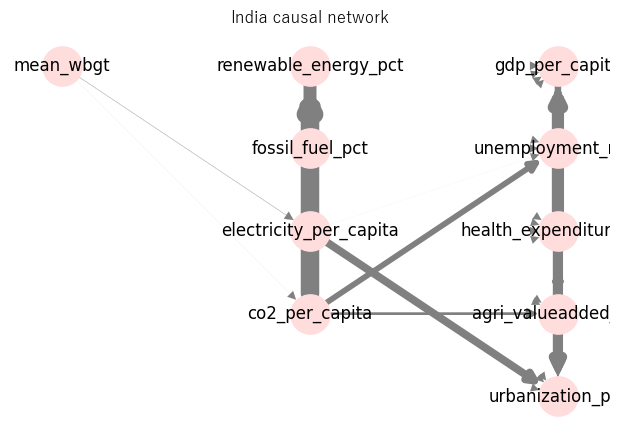

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

layer_map = {
    "mean_wbgt": 0,
    "renewable_energy_pct": 1,
    "fossil_fuel_pct": 1,
    "electricity_per_capita": 1,
    "co2_per_capita": 1,
    "gdp_per_capita": 2,
    "unemployment_rate": 2,
    "health_expenditure_pct": 2,
    "agri_valueadded_pct": 2,
    "urbanization_pct": 2
}

# 例として、”India” のネットワークを可視化
country = "India"
df_ct = df_edges[df_edges["country"] == country]

G = nx.DiGraph()
G.add_nodes_from(numeric_cols)
for _, row in df_ct.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["weight"])

# レイアウトを層ごとに固定したい場合
pos = {}
layer_positions = {
    0: (0.0, 0.5),  # 気候層は左側
    1: (0.5, 0.5),  # エネルギー層は中央
    2: (1.0, 0.5)   # 社会経済層は右側
}
# 各層の高低も少しずらすと見やすい
offset = 0.2
for i, node in enumerate(numeric_cols):
    layer = layer_map[node]
    # たとえば同じ層内で縦に offset ずらして配置
    idx_in_layer = sum(1 for x in numeric_cols[:i] if layer_map[x] == layer)
    pos[node] = (
        layer_positions[layer][0],
        layer_positions[layer][1] - offset * (idx_in_layer - 1)
    )

plt.figure(figsize=(6,4))
# エッジの太さを重みに比例させる
weights = [abs(G[u][v]["weight"]) * 5 for u, v in G.edges()]  # 5 はスケーリング係数
nx.draw(
    G, pos,
    with_labels=True,
    arrowsize=15,
    node_size=800,
    node_color="#ffdddd",
    edge_color="gray",
    width=weights
)
plt.title(f"{country} causal network")
plt.axis("off")
plt.show()


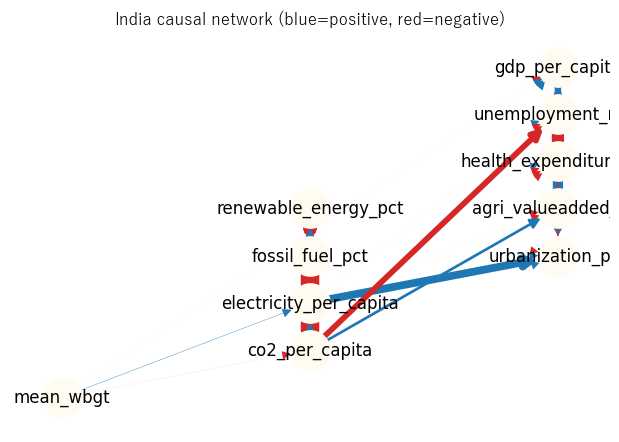

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# 例：“India” のネットワークを可視化
country = "India"
df_ct = df_edges[df_edges["country"] == country]

# 1) DiGraph を作成し、正負をチェックしながらエッジに color 属性を付与
G = nx.DiGraph()
for node in numeric_cols:
    G.add_node(node)

for _, row in df_ct.iterrows():
    src, tgt, w = row["source"], row["target"], row["weight"]
    if w >= 0:
        color = "tab:blue"   # 正の因果効果は青
    else:
        color = "tab:red"    # 負の因果効果は赤
    G.add_edge(src, tgt, weight=w, color=color)

# 2) レイアウトを層別に固定（例: x 座標を層ごとに決める）
pos = {}
layer_positions = {0: 0.0, 1: 0.5, 2: 1.0}
offset = 0.2
for i, node in enumerate(numeric_cols):
    layer = layer_map[node]
    idx_in_layer = sum(1 for x in numeric_cols[:i] if layer_map[x] == layer)
    pos[node] = (
        layer_positions[layer],
        layer_positions[layer] - offset * (idx_in_layer - (sum(layer_map[n]==layer for n in numeric_cols)/2))
    )

# 3) エッジの太さ (絶対値に比例)
edge_weights = [abs(G[u][v]["weight"]) * 5 for u, v in G.edges()]

# 4) エッジ色リストを取得
edge_colors = [G[u][v]["color"] for u, v in G.edges()]

plt.figure(figsize=(6,4))
nx.draw(
    G, pos,
    with_labels=True,
    arrowsize=15,
    node_size=800,
    node_color="#fffbf0",
    edge_color=edge_colors,      # ここで正負ごとに色指定
    width=edge_weights
)
plt.title(f"{country} causal network (blue=positive, red=negative)")
plt.axis("off")
plt.show()


## ノードごとの因果強度を国別に集計する

In [23]:
import pandas as pd
import networkx as nx

# すでに得られている「国別エッジリスト」を読み込む
# カラム： country, source, target, weight
df_edges = pd.read_csv("../data/processed/panel/edges_per_country.csv")

# 分析結果をためるリスト
degree_list = []

# numeric_cols, layer_map はあらかじめ定義済みとする
# 例えば:
# numeric_cols = [
#     "mean_wbgt",
#     "renewable_energy_pct","fossil_fuel_pct","electricity_per_capita","co2_per_capita",
#     "gdp_per_capita","unemployment_rate","health_expenditure_pct","agri_valueadded_pct","urbanization_pct"
# ]
# layer_map = {"mean_wbgt":0, "renewable_energy_pct":1, ... }

# 国ごとにループして DiGraph を作成し、次数・強度を計算
for country, df_ct in df_edges.groupby("country"):
    G = nx.DiGraph()
    # ノードを必ず全部追加しておく
    for node in numeric_cols:
        G.add_node(node)
    # エッジを追加
    for _, row in df_ct.iterrows():
        G.add_edge(row["source"], row["target"], weight=row["weight"])
    # ノードごとの in/out strength を計算
    for node in numeric_cols:
        # 入次数・出次数 (エッジ数ベース)
        in_deg  = G.in_degree(node)
        out_deg = G.out_degree(node)
        # 入強度・出強度 (重みベース)
        in_strength  = sum(abs(d["weight"]) for u, v, d in G.in_edges(node, data=True))
        out_strength = sum(abs(d["weight"]) for u, v, d in G.out_edges(node, data=True))
        degree_list.append({
            "country": country,
            "node": node,
            "in_degree": in_deg,
            "out_degree": out_deg,
            "in_strength": in_strength,
            "out_strength": out_strength
        })

# DataFrame 化して CSV に保存
df_node_strengths = pd.DataFrame(degree_list)
df_node_strengths.to_csv("../data/processed/panel/node_strengths_per_country.csv", index=False)
print("ノード強度を国別に保存しました: data/processed/panel/node_strengths_per_country.csv")
print(df_node_strengths.head(10))


ノード強度を国別に保存しました: data/processed/panel/node_strengths_per_country.csv
      country                    node  in_degree  out_degree  in_strength  \
0  Bangladesh               mean_wbgt          0           3     0.000000   
1  Bangladesh    renewable_energy_pct          4           3     0.443432   
2  Bangladesh         fossil_fuel_pct          1           8     1.679070   
3  Bangladesh  electricity_per_capita          2           5     0.000102   
4  Bangladesh          co2_per_capita          2           4     0.885188   
5  Bangladesh          gdp_per_capita          6           3     0.002194   
6  Bangladesh       unemployment_rate          4           4     0.000044   
7  Bangladesh  health_expenditure_pct          8           4     3.477175   
8  Bangladesh     agri_valueadded_pct          6           3     0.994469   
9  Bangladesh        urbanization_pct          7           3     1.376210   

   out_strength  
0      0.076281  
1      1.723612  
2      1.473799  
3      2.44

## 層ごとの総強度を国別に集計する
- 「Climate → Energy 層合計」「Energy → Socio‐Econ 層合計」を国別にまとめる。
- 以下のコード例では、mean_wbgt（気候層）→エネルギー層変数 の全てのエッジ重みを合計し、同様にエネルギー層変数→社会経済層変数 の重みを合計。
- どの国が気候からエネルギーへ、あるいはエネルギーから社会経済へ因果効果が強いかがわかる

In [24]:
import pandas as pd

# すでに df_edges を読み込んでいる前提

results = []
energy_nodes = ["renewable_energy_pct","fossil_fuel_pct","electricity_per_capita","co2_per_capita"]
socio_nodes  = ["gdp_per_capita","unemployment_rate","health_expenditure_pct","agri_valueadded_pct","urbanization_pct"]

for country, df_ct in df_edges.groupby("country"):
    # Climate → Energy 層合計
    ce_sum = df_ct[
        (df_ct["source"] == "mean_wbgt") &
        (df_ct["target"].isin(energy_nodes))
    ]["weight"].abs().sum()

    # Energy → Socio‐Econ 層合計
    es_sum = df_ct[
        (df_ct["source"].isin(energy_nodes)) &
        (df_ct["target"].isin(socio_nodes))
    ]["weight"].abs().sum()

    results.append({
        "country": country,
        "sum_climate_to_energy": ce_sum,
        "sum_energy_to_socio": es_sum
    })

df_layer_strength = pd.DataFrame(results)
df_layer_strength.to_csv("../data/processed/panel/layer_strengths_per_country.csv", index=False)
print("層別強度を国別に保存しました: data/processed/panel/layer_strengths_per_country.csv")
print(df_layer_strength)


層別強度を国別に保存しました: data/processed/panel/layer_strengths_per_country.csv
      country  sum_climate_to_energy  sum_energy_to_socio
0  Bangladesh               0.000574             3.465793
1       India               0.061024             2.339112
2       Nepal               0.000165             1.101186
3    Pakistan               0.132885             0.000335
4   Sri Lanka               0.000015             4.343651


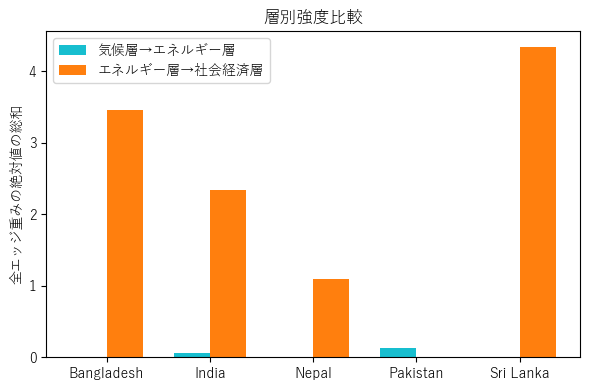

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = "Yu Gothic"
df_layer_strength = pd.read_csv("../data/processed/panel/layer_strengths_per_country.csv")
df_layer_strength.set_index("country", inplace=True)

plt.figure(figsize=(6,4))
x = df_layer_strength.index.tolist()
ce = df_layer_strength["sum_climate_to_energy"].values
es = df_layer_strength["sum_energy_to_socio"].values

bar_width = 0.35
idx = range(len(x))

plt.bar(idx, ce, width=bar_width, label="気候層→エネルギー層", color="tab:cyan")
plt.bar([i+bar_width for i in idx], es, width=bar_width, label="エネルギー層→社会経済層", color="tab:orange")

plt.xticks([i+bar_width/2 for i in idx], x, rotation=0)
plt.ylabel("全エッジ重みの絶対値の総和")#Absolute Sum of Weights
plt.title("層別強度比較")#層別強度比較（国別）Intensity for each layer
plt.legend()
plt.tight_layout()
plt.savefig('../results/intensity_for_each_layer.png')
plt.show()

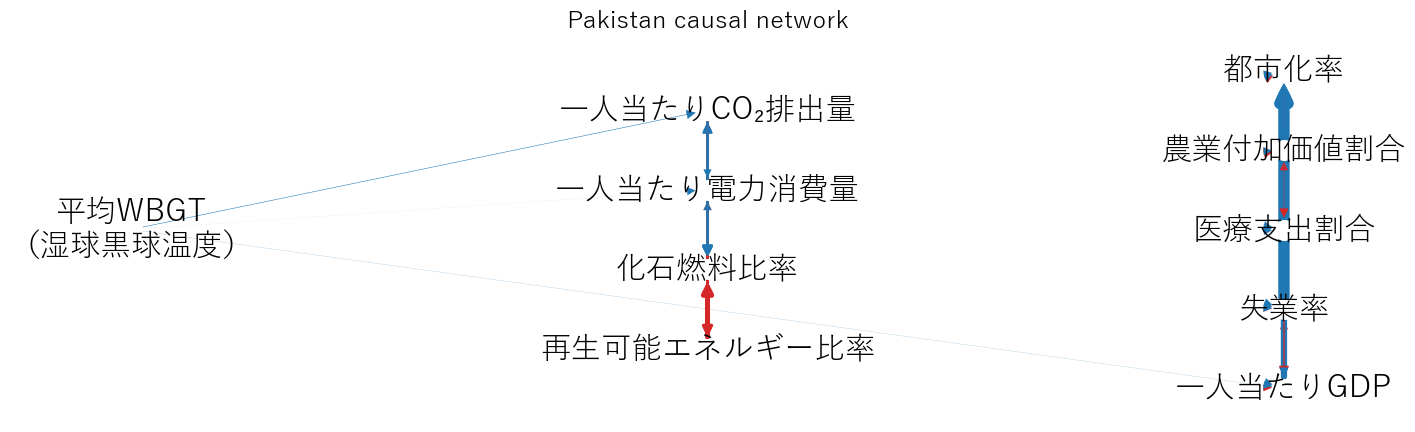

In [36]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

ja_label_map = {
    "mean_wbgt": "平均WBGT\n（湿球黒球温度）",
    "renewable_energy_pct": "再生可能エネルギー比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり電力消費量",
    "co2_per_capita": "一人当たりCO₂排出量",
    "gdp_per_capita": "一人当たりGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出割合",
    "agri_valueadded_pct": "農業付加価値割合",
    "urbanization_pct": "都市化率"
}

# 例：可視化したい国名を指定
country = "Pakistan"
df_ct = df_edges[df_edges["country"] == country]

# 1) DiGraph を作成し、正負でエッジ色を分ける
G = nx.DiGraph()
for node in numeric_cols:
    G.add_node(node)

for _, row in df_ct.iterrows():
    src, tgt, w = row["source"], row["target"], row["weight"]
    color = "tab:blue" if w >= 0 else "tab:red"
    G.add_edge(src, tgt, weight=w, color=color)

# 2) 固定レイアウトを決める（層ごとに x を分け、層内で y をずらす）
pos = {}
layer_positions = {0: 0.0, 1: 0.5, 2: 1.0}
offset = 0.2
for i, node in enumerate(numeric_cols):
    layer = layer_map[node]
    # 同じ層内でいくつ目かをカウント
    idx_in_layer = sum(1 for x in numeric_cols[:i] if layer_map[x] == layer)
    total_in_layer = sum(1 for x in numeric_cols if layer_map[x] == layer)
    # y座標を層の中心(0.5)から offset ずらして配置
    y_center = 0.5
    y = y_center + offset * (idx_in_layer - (total_in_layer - 1)/2)
    pos[node] = (layer_positions[layer], y)

# 3) エッジの太さを絶対値に比例させる
edge_weights = [abs(G[u][v]["weight"]) * 3.0 for u, v in G.edges()]
edge_colors  = [G[u][v]["color"] for u, v in G.edges()]

#     mapping: 英語ノード → 日本語ノード名
ja_labels = {node: ja_label_map.get(node, node) for node in numeric_cols}

plt.figure(figsize=(18,5))
nx.draw_networkx_nodes(
    G, pos,
    node_size=200,
    node_color="#ffffff"
)
# draw_networkx_labels に font_properties を渡す（日本語対応）
nx.draw_networkx_labels(
    G, pos,
    labels=ja_labels,
    font_size=22,
    font_family="Yu Gothic"
)

nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=15,
    edge_color=edge_colors,
    width=edge_weights
)

plt.title(f"{country} causal network", fontsize=18)
plt.axis("off")
plt.savefig("../results/causal_net_"+country+".svg")
plt.savefig("../results/causal_net_"+country+".png")
plt.show()


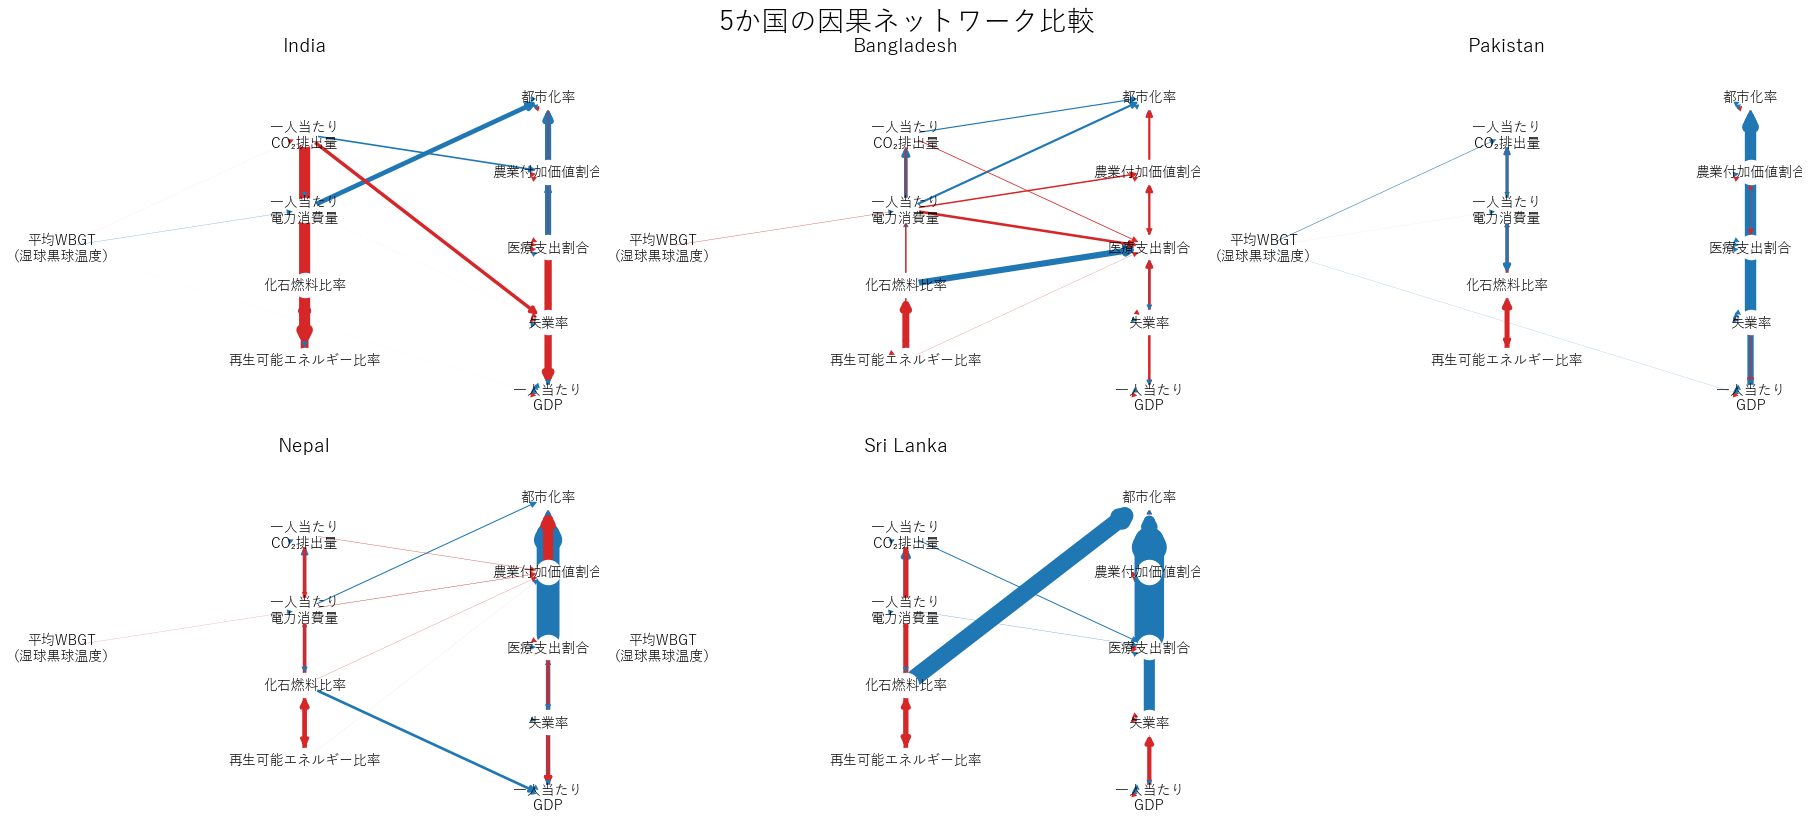

In [46]:
import os
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────
# 日本語ラベルマップ（共通）
# ─────────────────────────────────────────────
ja_label_map = {
    "mean_wbgt": "平均WBGT\n（湿球黒球温度）",
    "renewable_energy_pct": "再生可能エネルギー比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり\n電力消費量",
    "co2_per_capita": "一人当たり\nCO₂排出量",
    "gdp_per_capita": "一人当たり\nGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出割合",
    "agri_valueadded_pct": "農業付加価値割合",
    "urbanization_pct": "都市化率"
}

# ─────────────────────────────────────────────
# ノードリストと層マップ（全体で共通）
# ─────────────────────────────────────────────
numeric_cols = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita",
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

layer_map = {
    "mean_wbgt": 0,
    "renewable_energy_pct": 1,
    "fossil_fuel_pct": 1,
    "electricity_per_capita": 1,
    "co2_per_capita": 1,
    "gdp_per_capita": 2,
    "unemployment_rate": 2,
    "health_expenditure_pct": 2,
    "agri_valueadded_pct": 2,
    "urbanization_pct": 2
}

# ─────────────────────────────────────────────
# 国別エッジリストを読み込み
#    カラム: country, source, target, weight
# ─────────────────────────────────────────────
df_edges = pd.read_csv("../data/processed/panel/edges_per_country.csv")

# 2行×3列で並べたい国のリスト（5か国 + 空１箇所）
countries = ["India", "Bangladesh", "Pakistan", "Nepal", "Sri Lanka"]

# ─────────────────────────────────────────────
# サブプロットを 2行×3列 で作成
# ─────────────────────────────────────────────
nrows, ncols = 2, 3
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6 * ncols, 4 * nrows),  # 幅を7×列数、縦を6×行数に拡大
    constrained_layout=True
)

# ─────────────────────────────────────────────
# 各国ごとに因果ネットワークを描画
# ─────────────────────────────────────────────
for idx, country in enumerate(countries):
    ax = axes.flat[idx]
    df_ct = df_edges[df_edges["country"] == country]
    
    # --- 有向グラフを構築 ---
    G = nx.DiGraph()
    G.add_nodes_from(numeric_cols)
    for _, row in df_ct.iterrows():
        src, tgt, w = row["source"], row["target"], row["weight"]
        color = "tab:blue" if w >= 0 else "tab:red"
        G.add_edge(src, tgt, weight=w, color=color)
    
    # --- 固定レイアウトを計算 ---
    pos = {}
    layer_positions = {0: 0.0, 1: 0.5, 2: 1.0}
    offset = 0.2
    for i, node in enumerate(numeric_cols):
        layer = layer_map[node]
        idx_in_layer = sum(1 for x in numeric_cols[:i] if layer_map[x] == layer)
        total_in_layer = sum(1 for x in numeric_cols if layer_map[x] == layer)
        y_center = 0.5
        y = y_center + offset * (idx_in_layer - (total_in_layer - 1) / 2)
        pos[node] = (layer_positions[layer], y)
    
    # --- エッジの太さと色リスト ---
    edge_weights = [abs(G[u][v]["weight"]) * 3.0 for u, v in G.edges()]
    edge_colors  = [G[u][v]["color"] for u, v in G.edges()]
    
    # --- 日本語ノードラベル ---
    ja_labels = {node: ja_label_map.get(node, node) for node in numeric_cols}
    
    # --- ノード描画 ---
    nx.draw_networkx_nodes(
        G, pos,
        ax=ax,
        node_size=300,
        node_color="#ffffff"
    )
    # --- ノードラベル （日本語、Yu Gothic 推奨、小さめフォント）---
    nx.draw_networkx_labels(
        G, pos,
        labels=ja_labels,
        ax=ax,
        font_size=10,
        font_family="Yu Gothic"
    )
    
    # --- エッジ描画（直線）---
    nx.draw_networkx_edges(
        G, pos,
        ax=ax,
        arrowstyle='-|>',
        arrowsize=10,
        edge_color=edge_colors,
        width=edge_weights
    )
    
    ax.set_title(country, fontsize=14, pad=10)
    ax.axis("off")

# 余ったサブプロットを削除（6枠中5が使用）
for j in range(len(countries), nrows * ncols):
    fig.delaxes(axes.flat[j])

# 図全体タイトル
fig.suptitle("5か国の因果ネットワーク比較", fontsize=20, y=1.03)

# ─────────────────────────────────────────────
# 図を保存
# ─────────────────────────────────────────────
os.makedirs("../results", exist_ok=True)
out_svg = "../results/combined_causal_networks_2x3_adjusted.svg"
out_png = "../results/combined_causal_networks_2x3_adjusted.png"
fig.savefig(out_svg, dpi=150)
fig.savefig(out_png, dpi=150)
plt.show()


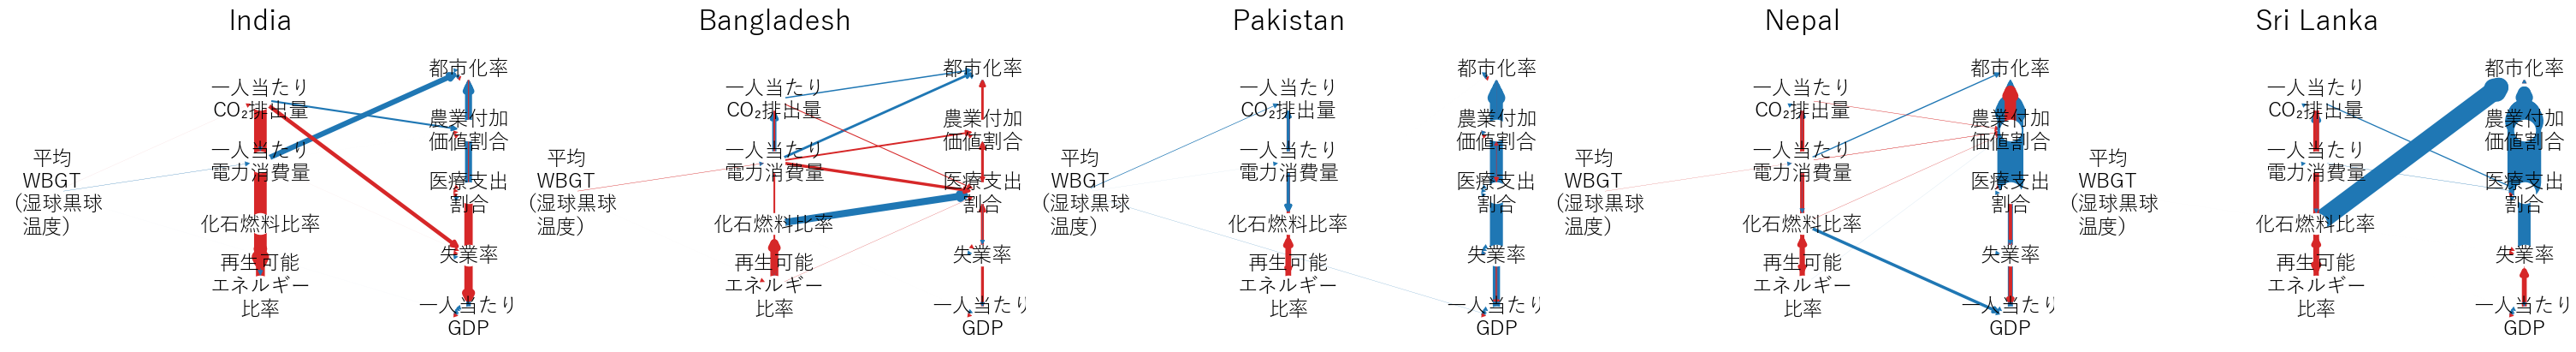

In [65]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────
# 日本語ラベルマップ（共通）
# ─────────────────────────────────────────────
ja_label_map = {
    "mean_wbgt": "平均\nWBGT\n（湿球黒球\n温度）",
    "renewable_energy_pct": "再生可能\nエネルギー\n比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり\n電力消費量",
    "co2_per_capita": "一人当たり\nCO₂排出量",
    "gdp_per_capita": "一人当たり\nGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出\n割合",
    "agri_valueadded_pct": "農業付加\n価値割合",
    "urbanization_pct": "都市化率"
}

# ─────────────────────────────────────────────
# ノードリストと層マップ（全体で共通）
# ─────────────────────────────────────────────
numeric_cols = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita",
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

layer_map = {
    "mean_wbgt": 0,
    "renewable_energy_pct": 1,
    "fossil_fuel_pct": 1,
    "electricity_per_capita": 1,
    "co2_per_capita": 1,
    "gdp_per_capita": 2,
    "unemployment_rate": 2,
    "health_expenditure_pct": 2,
    "agri_valueadded_pct": 2,
    "urbanization_pct": 2
}

# ─────────────────────────────────────────────
# 国別エッジリストを読み込み
#    カラム: country, source, target, weight
# ─────────────────────────────────────────────
df_edges = pd.read_csv("../data/processed/panel/edges_per_country.csv")

# 1行×5列で並べたい国のリスト
countries = ["India", "Bangladesh", "Pakistan", "Nepal", "Sri Lanka"]

# ─────────────────────────────────────────────
# サブプロットを 1行×5列 で作成
# ─────────────────────────────────────────────
nrows, ncols = 1, 5
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6.0 * ncols, 4),  # 幅を6×5=30、縦を4で横長かつ高さ抑えめ
    constrained_layout=True
)

# ─────────────────────────────────────────────
# 各国ごとに因果ネットワークを描画
# ─────────────────────────────────────────────
for idx, country in enumerate(countries):
    ax = axes[idx]
    df_ct = df_edges[df_edges["country"] == country]
    
    # --- 有向グラフを構築 ---
    G = nx.DiGraph()
    G.add_nodes_from(numeric_cols)
    for _, row in df_ct.iterrows():
        src, tgt, w = row["source"], row["target"], row["weight"]
        color = "tab:blue" if w >= 0 else "tab:red"
        G.add_edge(src, tgt, weight=w, color=color)
    
    # --- 固定レイアウトを計算 ---
    pos = {}
    layer_positions = {0: 0.0, 1: 0.5, 2: 1.0}
    offset = 0.2
    for i, node in enumerate(numeric_cols):
        layer = layer_map[node]
        idx_in_layer = sum(1 for x in numeric_cols[:i] if layer_map[x] == layer)
        total_in_layer = sum(1 for x in numeric_cols if layer_map[x] == layer)
        y_center = 0.5
        y = y_center + offset * (idx_in_layer - (total_in_layer - 1) / 2)
        pos[node] = (layer_positions[layer], y)
    
    # --- エッジの太さと色リスト ---
    edge_weights = [abs(G[u][v]["weight"]) * 4.0 for u, v in G.edges()]
    edge_colors  = [G[u][v]["color"] for u, v in G.edges()]
    
    # --- 日本語ノードラベル ---
    ja_labels = {node: ja_label_map.get(node, node) for node in numeric_cols}
    
    # --- ノード描画 ---
    nx.draw_networkx_nodes(
        G, pos,
        ax=ax,
        node_size=300,
        node_color="#ffffff"
    )
    # --- ノードラベル（日本語、Yu Gothic 使用推奨、小さめフォント）---
    nx.draw_networkx_labels(
        G, pos,
        labels=ja_labels,
        ax=ax,
        font_size=17,
        font_family="Yu Gothic"
    )
    
    # --- エッジ描画（弧を描く）---
    nx.draw_networkx_edges(
        G, pos,
        ax=ax,
        arrowstyle='-|>',
        arrowsize=10,
        edge_color=edge_colors,
        width=edge_weights
        # connectionstyle='arc3,rad=0.1'  # 弧を描く
    )
    
    ax.set_title(country, fontsize=24, pad=10)
    ax.axis("off")

# 余ったサブプロット（今回は5枠すべて使用するため不要）を削除（念のため）
for j in range(len(countries), nrows * ncols):
    fig.delaxes(axes[j])

# 図全体タイトル
# fig.suptitle("5か国の因果ネットワーク比較", fontsize=18, y=1.05)

# ─────────────────────────────────────────────
# 図を保存
# ─────────────────────────────────────────────
os.makedirs("../results", exist_ok=True)
out_svg = "../results/combined_causal_networks_1x5.svg"
out_png = "../results/combined_causal_networks_1x5.png"
fig.savefig(out_svg)
fig.savefig(out_png)
plt.show()


## 「二段階パスの強度」を国別に比較する
例：mean_wbgt → renewable_energy_pct → gdp_per_capita のパス強度を計算し、国ごとの違いをテーブル・グラフ化する。

In [27]:
# 簡易例：各国の 『WBGT→renewable→GDP』 の重み積を計算
results_path = []
for country, df_ct in df_edges.groupby("country"):
    # まずリスト形式のエッジを辞書にしておく
    edge_dict = {(row.source, row.target): row.weight for row in df_ct.itertuples()}
    # パス強度 = weight(WBGT→renew) * weight(renew→gdp)
    w1 = edge_dict.get(("mean_wbgt", "renewable_energy_pct"), 0)
    w2 = edge_dict.get(("renewable_energy_pct", "gdp_per_capita"), 0)
    path_strength = w1 * w2
    results_path.append({
        "country": country,
        "path_WBGT_renew_GDP": path_strength
    })
df_path = pd.DataFrame(results_path)
df_path.to_csv("../data/processed/panel/path_strength_WBGT_renew_GDP.csv", index=False)
print(df_path)


      country  path_WBGT_renew_GDP
0  Bangladesh         3.560234e-09
1       India        -0.000000e+00
2       Nepal         0.000000e+00
3    Pakistan        -0.000000e+00
4   Sri Lanka        -0.000000e+00


## 「ノード中心性」や「クラスター係数」を計算して比較する
例：NetworkX の nx.betweenness_centrality(G) を使って、各国のグラフで中心的なノードを特定する。

In [28]:
import pandas as pd
import networkx as nx

# 1. 国別エッジリストを読み込む
#    CSV のカラム: country, source, target, weight
df_edges = pd.read_csv("../data/processed/panel/edges_per_country.csv")

# 2. すべての国、すべてのノードをあらかじめリスト化しておく
numeric_cols = [
    "mean_wbgt",
    "renewable_energy_pct", "fossil_fuel_pct", "electricity_per_capita", "co2_per_capita",
    "gdp_per_capita", "unemployment_rate", "health_expenditure_pct", "agri_valueadded_pct", "urbanization_pct"
]

# 3. 結果をためるリストを用意
centrality_list = []

# 4. 国ごとにグラフを構築し、中心性とクラスター係数を計算
for country, df_ct in df_edges.groupby("country"):
    # ---- (A) 有向グラフを作成（重み付き） ----
    G = nx.DiGraph()
    # 全ノードを追加しておく（孤立ノードがあっても存在を保証）
    G.add_nodes_from(numeric_cols)
    # 国別のエッジを追加（エッジ属性に 'weight' を持たせる）
    for _, row in df_ct.iterrows():
        src, tgt, w = row["source"], row["target"], row["weight"]
        G.add_edge(src, tgt, weight=w)
    
    # ---- (B) ノードごとに各種中心性を計算 ----
    #  1) Betweenness Centrality（重みなし/有向）: 
    #     デフォルトでは“重みなし”扱い  →  引数 "weight" を渡すと”重み考慮”になるが、
    #     NOTEARS の重みは因果強度なので、重み付き算出も可能。
    #     ここでは “重み付き” で計算してみる例を示す。
    bc = nx.betweenness_centrality(G, weight="weight", normalized=True)
    #  2) Degree Centrality（有向）: 
    #     out-degree と in-degree を分けて計算。重みベースではなく次数ベースです。
    out_deg = dict(G.out_degree())
    in_deg  = dict(G.in_degree())
    #  3) Weighted Degree（強度ベース）:
    #     out_strength と in_strength を計算（絶対値の総和）
    out_strength = {node: sum(abs(d["weight"]) for _, _, d in G.out_edges(node, data=True))
                    for node in G.nodes()}
    in_strength  = {node: sum(abs(d["weight"]) for _, _, d in G.in_edges(node, data=True))
                    for node in G.nodes()}
    #  4) Clustering Coefficient（クラスター係数）:
    #     DiGraph には直接的な重み付きクラスタリングはないので、まず無向グラフに変換。
    #     ⇒ 方向を無視して重み付きクラスター係数を計算する
    G_und = G.to_undirected(reciprocal=False)
    # nx.clustering では重みのキーが "weight" であれば、自動的に“重み付き”を計算します
    clustering = nx.clustering(G_und, weight="weight")
    
    # ---- (C) 上記の各指標をまとめて結果リストに格納 ----
    for node in numeric_cols:
        centrality_list.append({
            "country": country,
            "node": node,
            "betweenness_centrality": bc.get(node, 0.0),
            "out_degree": out_deg.get(node, 0),
            "in_degree": in_deg.get(node, 0),
            "out_strength": out_strength.get(node, 0.0),
            "in_strength": in_strength.get(node, 0.0),
            "clustering_coefficient": clustering.get(node, 0.0)
        })

# 5. 結果を DataFrame 化して CSV 出力
df_centrality = pd.DataFrame(centrality_list)
df_centrality.to_csv("../data/processed/panel/node_centrality_per_country.csv", index=False)

print("ノード中心性・クラスター係数を国別に保存しました:")
print("  → data/processed/panel/node_centrality_per_country.csv")
print(df_centrality.head(12))


ノード中心性・クラスター係数を国別に保存しました:
  → data/processed/panel/node_centrality_per_country.csv
       country                    node  betweenness_centrality  out_degree  \
0   Bangladesh               mean_wbgt                0.000000           3   
1   Bangladesh    renewable_energy_pct                0.166667           3   
2   Bangladesh         fossil_fuel_pct                0.222222           8   
3   Bangladesh  electricity_per_capita                0.000000           5   
4   Bangladesh          co2_per_capita                0.000000           4   
5   Bangladesh          gdp_per_capita                0.000000           3   
6   Bangladesh       unemployment_rate                0.000000           4   
7   Bangladesh  health_expenditure_pct                0.291667           4   
8   Bangladesh     agri_valueadded_pct                0.388889           3   
9   Bangladesh        urbanization_pct                0.305556           3   
10       India               mean_wbgt                0.000

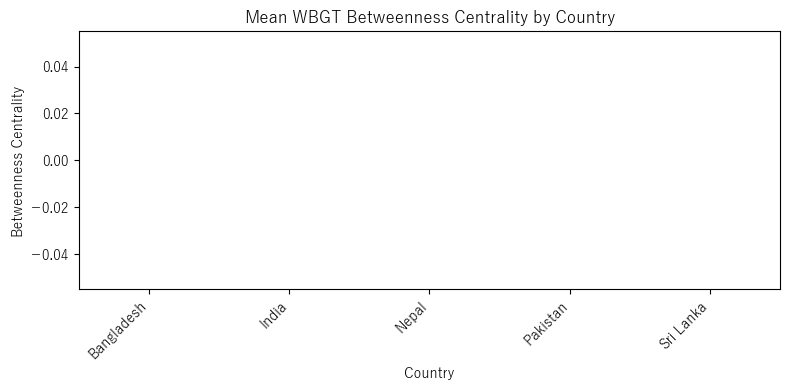

In [29]:
# Betweenness Centrality の可視化
# どの国で WBGT（熱ストレス指標）がネットワーク上で最もハブ的に働いているか
df_betw = df_centrality[df_centrality['node'] == 'mean_wbgt'][['country', 'betweenness_centrality']]
df_betw = df_betw.set_index('country')

plt.figure(figsize=(8, 4))
df_betw['betweenness_centrality'].plot(kind='bar', color='skyblue')
plt.title('Mean WBGT Betweenness Centrality by Country')
plt.ylabel('Betweenness Centrality')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

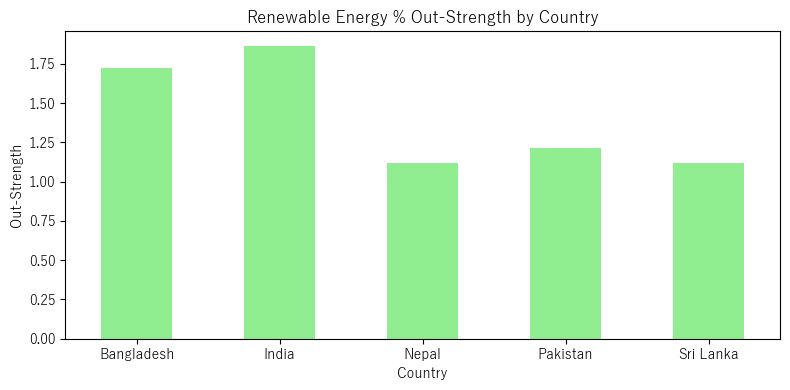

In [30]:
# Renewable Energy % の出強度（Out-Strength）の可視化
# どの国で再生可能エネルギー比率が他の変数に最も強い影響を与えているか
df_out_strength = df_centrality[df_centrality['node'] == 'renewable_energy_pct'][['country', 'out_strength']]
df_out_strength = df_out_strength.set_index('country')

plt.figure(figsize=(8, 4))
df_out_strength['out_strength'].plot(kind='bar', color='lightgreen')
plt.title('Renewable Energy % Out-Strength by Country')
plt.ylabel('Out-Strength')
plt.xlabel('Country')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.savefig('../results/renewable_energy_percent_out_strength_by_country.png')
plt.show()


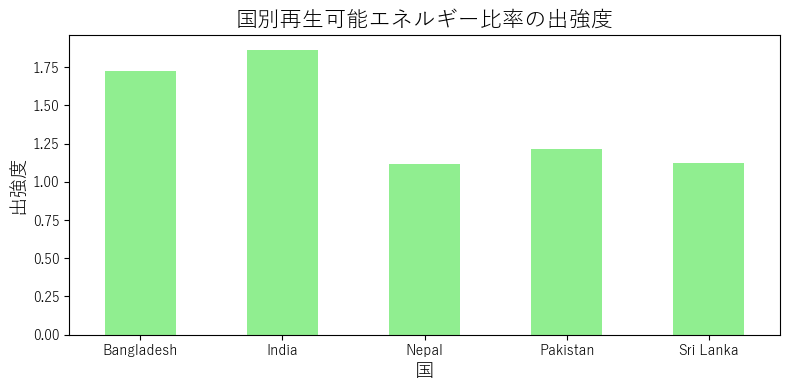

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# 日本語フォント設定（環境に合わせてフォント名を調整してください）
plt.rcParams['font.family'] = 'Yu Gothic'  # Yu Gothic など日本語対応フォントを指定

# ─────────────────────────────────────────────
# 中心性データを読み込む
# (例: "../data/processed/panel/node_centrality_per_country.csv")
df_centrality = pd.read_csv("../data/processed/panel/node_centrality_per_country.csv")

# ─────────────────────────────────────────────
# 再生可能エネルギー比率（renewable_energy_pct）のアウトストレングスを抽出
# ─────────────────────────────────────────────
df_out_strength = df_centrality[df_centrality['node'] == 'renewable_energy_pct'][['country', 'out_strength']]
df_out_strength = df_out_strength.set_index('country')

# ─────────────────────────────────────────────
# グラフ描画
# ─────────────────────────────────────────────
plt.figure(figsize=(8, 4))
df_out_strength['out_strength'].plot(kind='bar', color='lightgreen')

# 日本語タイトルと軸ラベル
plt.title('国別再生可能エネルギー比率の出強度', fontsize=16)
plt.ylabel('出強度', fontsize=14)
plt.xlabel('国', fontsize=14)

# X軸の回転と配置
plt.xticks(rotation=0, ha='center')

plt.tight_layout()
# plt.savefig('../results/renewable_energy_pct_out_strength_by_country.png')
plt.show()


どの国が再生可能エネルギーが他指標に影響しやすいか
インドやバングラディシュ＞ネパール、パキスタン、スリランカ

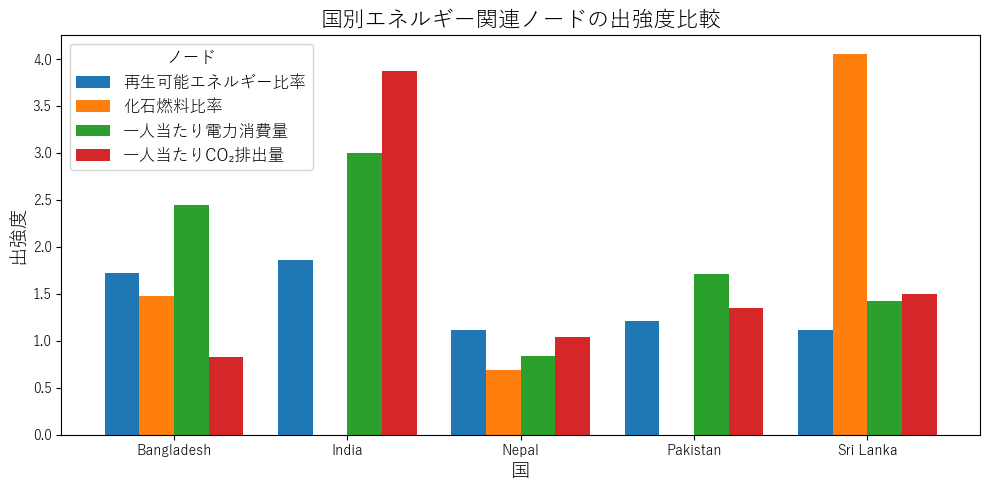

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 日本語フォント設定（環境に合わせてフォント名を調整してください）
plt.rcParams['font.family'] = 'Yu Gothic'

# ─────────────────────────────────────────────
# ノード中心性データを読み込む
# (例: "../data/processed/panel/node_centrality_per_country.csv")
df_centrality = pd.read_csv("../data/processed/panel/node_centrality_per_country.csv")

# ─────────────────────────────────────────────
# プロット対象ノードをリスト化
# ─────────────────────────────────────────────
target_nodes = [
    'renewable_energy_pct',
    'fossil_fuel_pct',
    'electricity_per_capita',
    'co2_per_capita'
]

# ─────────────────────────────────────────────
# 対象ノードの出強度を抽出してピボット
# ─────────────────────────────────────────────
df_sel = df_centrality[df_centrality['node'].isin(target_nodes)]
df_pivot = df_sel.pivot(index='country', columns='node', values='out_strength')

# ─────────────────────────────────────────────
# 棒グラフ描画（国を横軸に、ノード別グループ化）
# ─────────────────────────────────────────────
ax = df_pivot[target_nodes].plot(
    kind='bar',
    figsize=(10, 5),
    width=0.8
)

# タイトル・ラベルの設定
ax.set_title('国別エネルギー関連ノードの出強度比較', fontsize=16)
ax.set_xlabel('国', fontsize=14)
ax.set_ylabel('出強度', fontsize=14)

# 凡例ラベルを日本語にする
ja_labels = {
    'renewable_energy_pct': '再生可能エネルギー比率',
    'fossil_fuel_pct': '化石燃料比率',
    'electricity_per_capita': '一人当たり電力消費量',
    'co2_per_capita': '一人当たりCO₂排出量'
}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [ja_labels[l] for l in labels], title='ノード', fontsize=12, title_fontsize=12)

# X軸の目盛りを見やすく
plt.xticks(rotation=0, ha='center')
plt.tight_layout()

# 保存する場合
plt.savefig('../results/energy_out_strength_comparison.png', dpi=150)

plt.show()


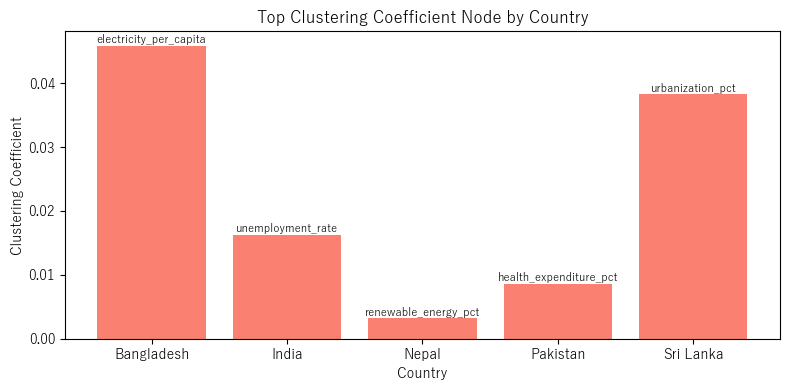

In [31]:
# クラスター係数が高いノードを国別に表示
# どの国でどのノードが最もクラスター化しているか」（閉じた相互依存グループの中心になりやすいか）
result = []
for country, group in df_centrality.groupby('country'):
    top_node = group.loc[group['clustering_coefficient'].idxmax()]
    result.append({
        'country': country,
        'node': top_node['node'],
        'clustering_coefficient': top_node['clustering_coefficient']
    })

df_top_clust = pd.DataFrame(result).set_index('country')

plt.figure(figsize=(8, 4))
plt.bar(df_top_clust.index, df_top_clust['clustering_coefficient'], color='salmon')
for i, (node, value) in enumerate(zip(df_top_clust['node'], df_top_clust['clustering_coefficient'])):
    plt.text(i, value + 0.0001, node, ha='center', va='bottom', fontsize=8, rotation=0)
plt.title('Top Clustering Coefficient Node by Country')
plt.ylabel('Clustering Coefficient')
plt.xlabel('Country')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.savefig('../results/top_clustering_coeff_node_by_country.png')
plt.show()


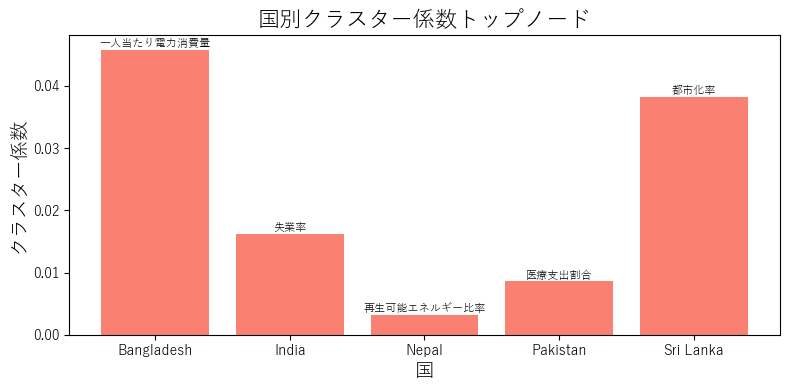

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# 日本語フォント設定（環境に合わせてフォント名を調整してください）
plt.rcParams['font.family'] = 'Yu Gothic'

# 日本語ラベルマップ（ノード名を英語から日本語に変換）
ja_label_map = {
    "mean_wbgt": "平均WBGT",
    "renewable_energy_pct": "再生可能エネルギー比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり電力消費量",
    "co2_per_capita": "一人当たりCO₂排出量",
    "gdp_per_capita": "一人当たりGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出割合",
    "agri_valueadded_pct": "農業付加価値割合",
    "urbanization_pct": "都市化率"
}

# ─────────────────────────────────────────────
# df_centrality: country, node, clustering_coefficient を含む DataFrame
# ─────────────────────────────────────────────

# 国別クラスター係数が最大のノードを抽出
result = []
for country, group in df_centrality.groupby('country'):
    top_node = group.loc[group['clustering_coefficient'].idxmax()]
    result.append({
        'country': country,
        'node': top_node['node'],
        'clustering_coefficient': top_node['clustering_coefficient']
    })

df_top_clust = pd.DataFrame(result).set_index('country')

# ─────────────────────────────────────────────
# 棒グラフ描画
# ─────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.bar(df_top_clust.index, df_top_clust['clustering_coefficient'], color='salmon')

# 棒の上に日本語ラベルのノード名を表示
for i, (node, value) in enumerate(zip(df_top_clust['node'], df_top_clust['clustering_coefficient'])):
    ja_node = ja_label_map.get(node, node)
    plt.text(i, value + 0.0001, ja_node, ha='center', va='bottom', fontsize=8, rotation=0)

# 日本語タイトルと軸ラベル
plt.title('国別クラスター係数トップノード', fontsize=16)
plt.ylabel('クラスター係数', fontsize=14)
plt.xlabel('国', fontsize=14)

# X軸の回転と配置
plt.xticks(rotation=0, ha='center')

plt.tight_layout()
plt.savefig('../results/top_clustering_coeff_node_by_country_jp.png')
plt.show()


Bangladeshでは electricity_per_capita、Sri Lankaでは urbanizaiton_pct が最もクラスター係数が高い = 閉じた構造の中心になりやすい

## 南アジア全体（プール推定）の3層因果ネットワーク

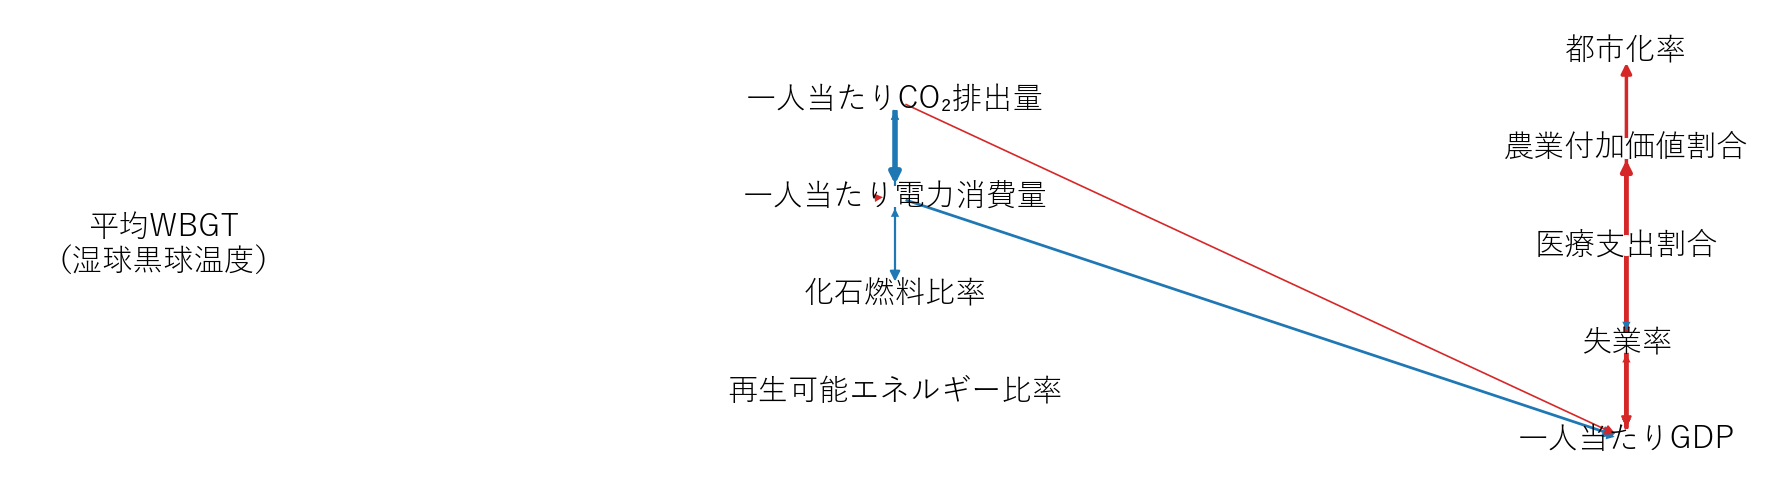

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# ─── 前提条件 ───
# 三層モデルを構成するノードのリストと層マップを定義済みであること

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx
import pandas as pd
import os

# ─────────────────────────────────────────────
# 0) 日本語ラベルマップ
# ─────────────────────────────────────────────
ja_label_map = {
    "mean_wbgt": "平均WBGT\n（湿球黒球温度）",
    "renewable_energy_pct": "再生可能エネルギー比率",
    "fossil_fuel_pct": "化石燃料比率",
    "electricity_per_capita": "一人当たり電力消費量",
    "co2_per_capita": "一人当たりCO₂排出量",
    "gdp_per_capita": "一人当たりGDP",
    "unemployment_rate": "失業率",
    "health_expenditure_pct": "医療支出割合",
    "agri_valueadded_pct": "農業付加価値割合",
    "urbanization_pct": "都市化率"
}

# ─────────────────────────────────────────────
# 1) フォント設定（日本語が文字化けしないように）
#    お使いの環境に日本語対応フォントが入っていない場合は、
#    事前にインストールするか、以下の path を修正してください。
# ─────────────────────────────────────────────

plt.rcParams['font.family'] = "Yu Gothic"

# ─────────────────────────────────────────────
# 2) ノードとレイアウトの準備
# ─────────────────────────────────────────────
numeric_cols = [
    "mean_wbgt",
    "renewable_energy_pct",
    "fossil_fuel_pct",
    "electricity_per_capita",
    "co2_per_capita",
    "gdp_per_capita",
    "unemployment_rate",
    "health_expenditure_pct",
    "agri_valueadded_pct",
    "urbanization_pct"
]

layer_map = {
    "mean_wbgt": 0,
    "renewable_energy_pct": 1,
    "fossil_fuel_pct": 1,
    "electricity_per_capita": 1,
    "co2_per_capita": 1,
    "gdp_per_capita": 2,
    "unemployment_rate": 2,
    "health_expenditure_pct": 2,
    "agri_valueadded_pct": 2,
    "urbanization_pct": 2
}

# ─────────────────────────────────────────────
# 3) エッジリストを読み込んでグラフ構築
# ─────────────────────────────────────────────
edge_path = "../data/processed/panel/edges_notears_filtered.csv"
df_edges = pd.read_csv(edge_path)

G = nx.DiGraph()
for node in numeric_cols:
    G.add_node(node)

for _, row in df_edges.iterrows():
    src, tgt, w = row["source"], row["target"], row["weight"]
    color = "tab:blue" if w >= 0 else "tab:red"
    G.add_edge(src, tgt, weight=w, color=color)

# ─────────────────────────────────────────────
# 4) 固定レイアウトを計算（層ごとに x、層内で y をずらす）
# ─────────────────────────────────────────────
pos = {}
layer_positions = {0: 0.0, 1: 0.5, 2: 1.0}
offset = 0.2

for i, node in enumerate(numeric_cols):
    layer = layer_map[node]
    idx_in_layer = sum(1 for x in numeric_cols[:i] if layer_map[x] == layer)
    total_in_layer = sum(1 for x in numeric_cols if layer_map[x] == layer)
    y_center = 0.5
    y = y_center + offset * (idx_in_layer - (total_in_layer - 1) / 2)
    pos[node] = (layer_positions[layer], y)

# ─────────────────────────────────────────────
# 5) エッジの太さ・色リストを作成
# ─────────────────────────────────────────────
edge_weights = [abs(G[u][v]["weight"]) * 3.5 for u, v in G.edges()]
edge_colors  = [G[u][v]["color"] for u, v in G.edges()]

# ─────────────────────────────────────────────
# 6) 描画
# ─────────────────────────────────────────────
plt.figure(figsize=(18, 5))

# (A) ノードを描画
nx.draw_networkx_nodes(
    G, pos,
    node_size=200,
    node_color="#ffffff"
)

# (B) 日本語ラベルを生成して渡す
#     mapping: 英語ノード → 日本語ノード名
ja_labels = {node: ja_label_map.get(node, node) for node in numeric_cols}

# draw_networkx_labels に font_properties を渡す（日本語対応）
nx.draw_networkx_labels(
    G, pos,
    labels=ja_labels,
    font_size=22,
    font_family="Yu Gothic"
)

# (C) エッジを描画 (曲線は不要な場合はコメントアウト)
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=15,
    edge_color=edge_colors,
    width=edge_weights
)

plt.axis("off")
plt.tight_layout()

# 保存フォルダがなければ作成
os.makedirs("../results", exist_ok=True)
plt.savefig("../results/causal_network_south_asia.png")
plt.savefig("../results/causal_network_south_asia.svg")
plt.show()